In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import fsps
import sedpy
import prospect
from prospect.utils.obsutils import fix_obs
from glob import glob
from prospect.models.templates import TemplateLibrary
from multiprocessing import Pool
from prospect.plotting.sfh import parametric_sfr
from prospect.plotting.utils import sample_posterior
from prospect.io import read_results as reader
from prospect.plotting.corner import quantile
import corner as corn

In [150]:
gal='UGC9379'
files={'MCG05':'./quickstart_emcee_MCG05_1.h5',
    'MCG06':'./quickstart_emcee_MCG06_2.h5',
    'NGC3016':'./quickstart_emcee_mcmc16.h5',
    'NGC6365A':'./quickstart_emcee_NGC6365A.h5',
    'NGC3705':'./quickstart_emcee_NGC3705.h5',
    'NVSSJ09': './quickstart_emcee_NVSSJ09_3.h5',
    'UGC9379':'./quickstart_emcee_UGC9379.h5'}
full_names={'NGC3705': 'NGC 3705',
    'MCG05': 'MCG+05-40-038',
    'MCG06': 'MCG+06-27-025',
    'NGC3016': 'NGC 3016',
    'NGC6365A': 'NGC 6365A',
    'UGC9379': 'UGC 9379',
    'NVSSJ09': 'NVSS J092456+402359'}
results_type = "emcee"
def create_walker_mask(cropped_chain,parameter_ind,min_val,max_val,checkind=-1):
    mask=np.zeros(128,dtype=bool)
    mask.fill(False)
    for i in range(len(mask)):
        val=cropped_chain[i,checkind,parameter_ind]
        if min_val<val and val<max_val:
            mask[i]=True
    return mask
hfile=files[gal]
result, obs, _ = reader.results_from(hfile.format(results_type), dangerous=False)

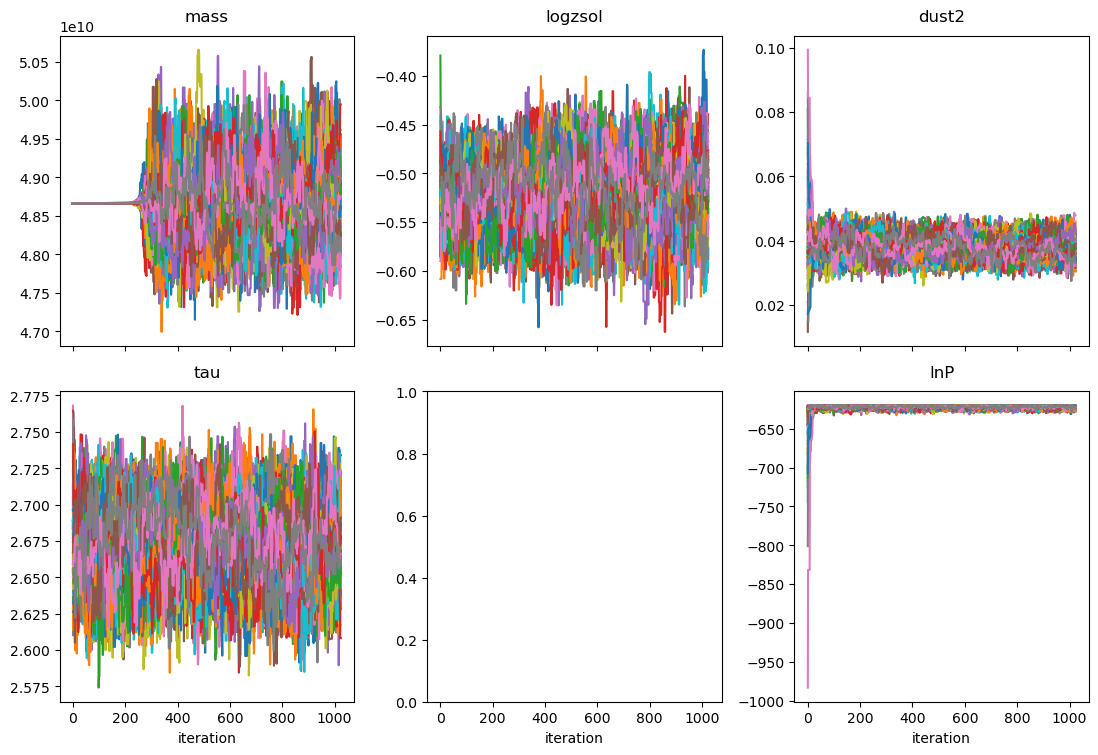

In [151]:
#Initial Diagnoses
tfig = reader.traceplot(result)
#cfig = reader.subcorner(result,start=800)

In [152]:

#walker_mask=create_walker_mask(result['chain'],1,-0.75,-0.45,checkind=-10)
walker_mask=np.full(128,True,dtype=bool)
print(walker_mask)
start=500
imax = np.argmax(result['lnprobability'][walker_mask,start:])
cropped_chain=result["chain"][walker_mask,start:,::]
csz = cropped_chain.shape
print(csz)
i, j = np.unravel_index(imax, result['lnprobability'][walker_mask,start:].shape)
print(i,j)
theta_max = cropped_chain[i, j, :].copy()
flatchain = cropped_chain.reshape(csz[0] * csz[1], csz[2])
# 16th, 50th, and 84th percentiles of the posterior
weights = result.get("weights", None)
print(flatchain.T.shape)
post_pcts = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)
print(post_pcts)
print(theta_max)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
(128, 524, 4)
84 147
(4, 67072)
[[ 4.82592264e+10  4.86508155e+10  4.90636538e+10]
 [-5.46365433e-01 -5.16073830e-01 -4.90402952e-01]
 [ 3.53211884e-02  3.82284356e-02  4.11211007e-02]
 [ 2.65128986e+00  2.67358744e+00  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


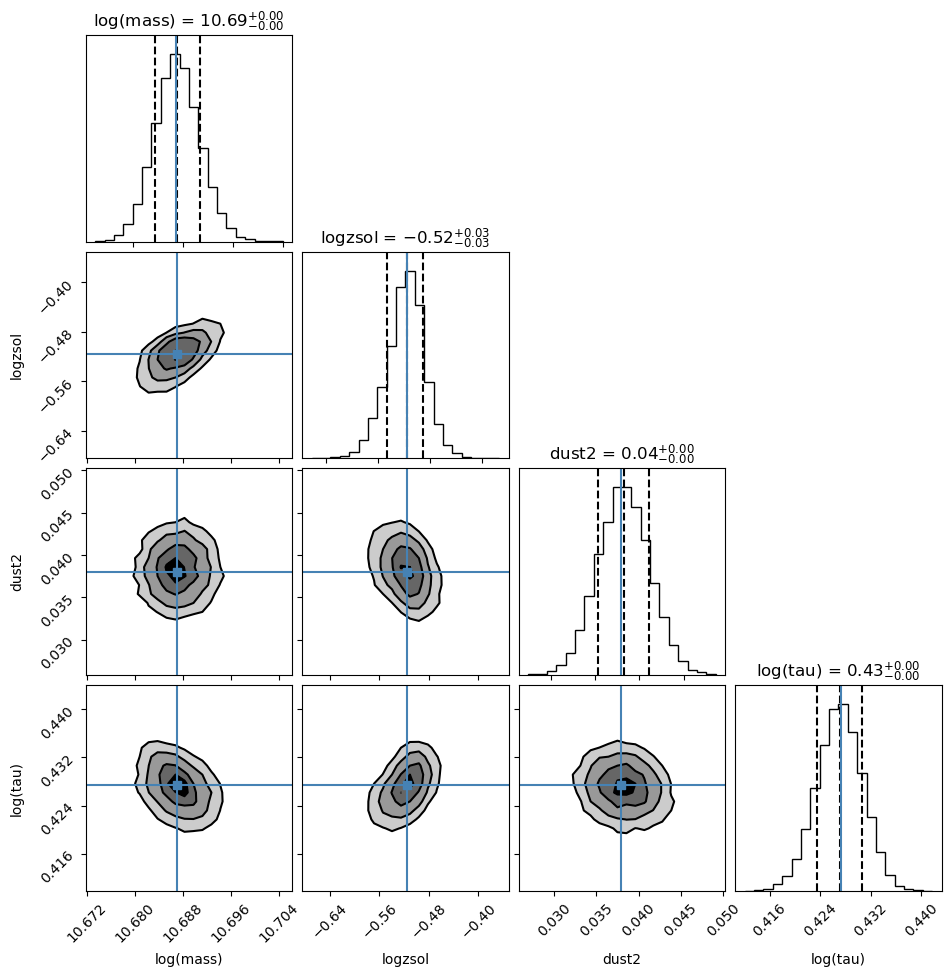

In [153]:
walker_inds=[num for num,val in enumerate(walker_mask) if val]
print(walker_inds)
cornerfig = reader.subcorner(result, start=500, thin=1, truths=theta_max, 
                               fig=plt.subplots(4,4,figsize=(10,10))[0],chains=walker_inds)
#plt.title(f'{full_names[gal]}')
# cornerfig = reader.subcorner(result, start=600, thin=5, truths=theta_max, 
#                                fig=plt.subplots(4,4,figsize=(10,10))[0],chains=walker_inds,range=[(9.158,9.17),(-0.7,-0.58),(0.09,0.12),(0.248,0.275)])

[10.69197561 10.6912926  10.6912926  ... 10.69101786 10.69101786
 10.69104783]


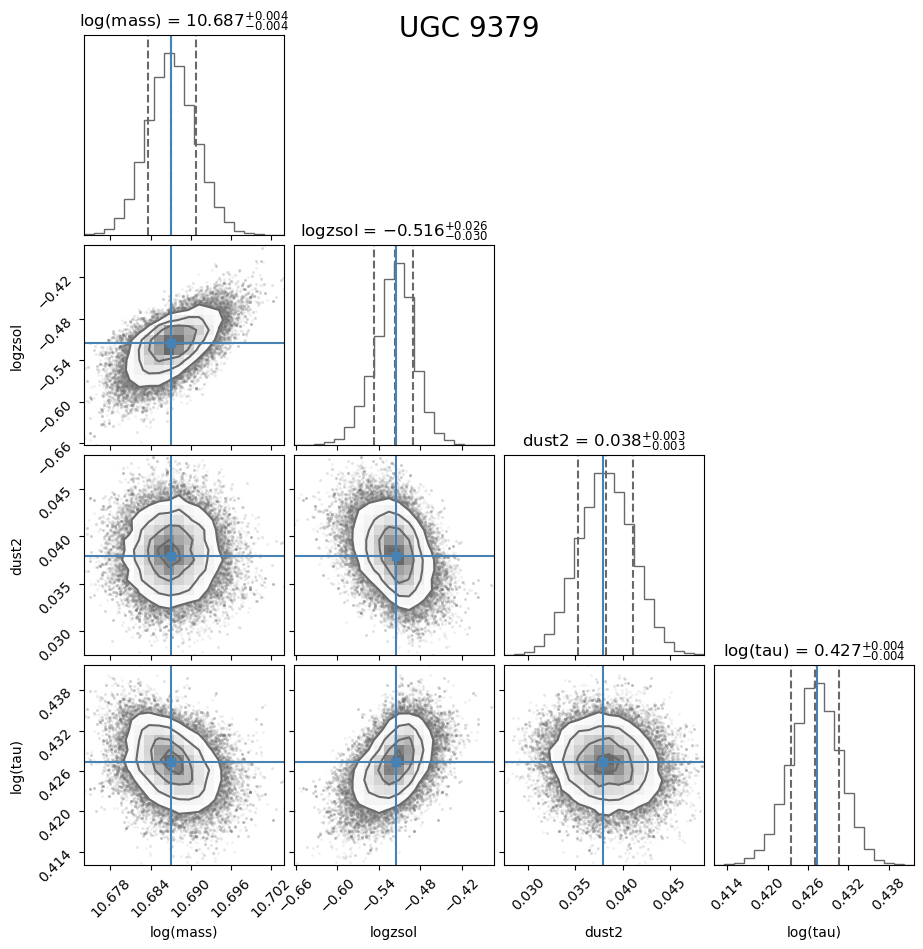

In [107]:
nice_colours=['darkorchid','dodgerblue','forestgreen','goldenrod','peru','mediumslateblue','firebrick','dimgrey']
corner_results=cropped_chain.copy().reshape(cropped_chain.shape[0] * cropped_chain.shape[1], cropped_chain.shape[2])
corner_results[::,0]=np.log10(corner_results[::,0])
corner_results[::,3]=np.log10(corner_results[::,3])
theta_max_corn=theta_max.copy()
theta_max_corn[0]=np.log10(theta_max_corn[0])
theta_max_corn[3]=np.log10(theta_max_corn[3])

print(corner_results[::,0])
#parnames = np.array(result['theta_labels'], dtype='U20')
parnames = np.array(['log(mass)','logzsol','dust2','log(tau)'], dtype='U20')
fig=corn.corner(corner_results,labels=parnames,show_titles=True,plot_contours=True,\
                truths=theta_max_corn,quantiles=[0.16,0.5,0.84],title_fmt='.3f',color=nice_colours[7])
fig.suptitle(f'{full_names[gal]}',fontsize=20)
plt.savefig(f'./Corner_Plots/{gal}.png')

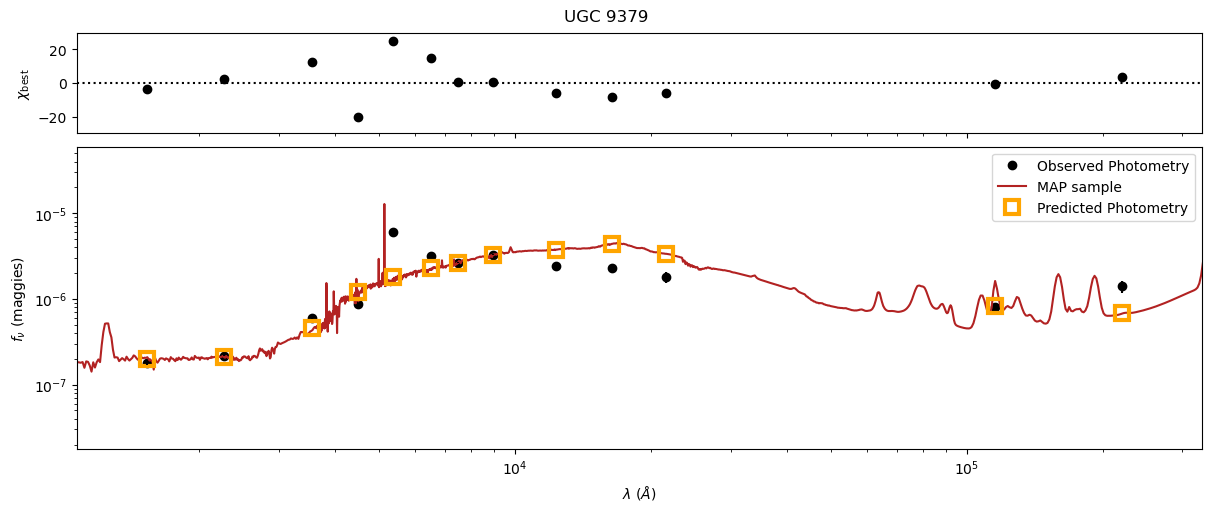

In [154]:
sfig, saxes = plt.subplots(2, 1,figsize=(12,5),gridspec_kw=dict(height_ratios=[1, 3]), sharex=True,layout='constrained')
mask=np.array([True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,True,True,True,True])
ax = saxes[1]
mask=result['obs']['phot_mask']
pwave = np.array([f.wave_effective for f in obs["filters"]])
# plot the data
ax.plot(pwave[mask], obs["maggies"][mask], linestyle="", marker="o", color="k",label='Observed Photometry')
#ax.plot(obs['wavelength'],obs['spectrum']*obs['wavelength'])
ax.errorbar(pwave[mask],  obs["maggies"][mask], obs["maggies_unc"][mask], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel("$\\lambda$ ($\\AA$)")
ax.set_xlim(0.7*np.min(pwave[mask]), 1.5*np.max(pwave[mask]))
ax.set_ylim(np.nanmin(obs["maggies"]) * 0.1, np.nanmax(obs["maggies"]) * 10)
ax.set_yscale("log")
ax.set_xscale("log")

# get the best-fit SED
bsed = result["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave[mask], bsed["photometry"][mask], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none",label='Predicted Photometry')
ax.legend()
ax = saxes[0]
chi = (obs["maggies"] - bsed["photometry"]) / obs["maggies_unc"]
ax.plot(pwave[mask], chi[mask], linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-30, 30)
ax.set_ylabel(r"$\chi_{\rm best}$")
sfig.suptitle(f'{full_names[gal]}')
plt.savefig(f'./SED fits/{gal}.png')

In [111]:
print(cropped_chain.shape)
print(sample_posterior(cropped_chain).shape)
flatchain1=cropped_chain.reshape(csz[0] * csz[1], csz[2])
print(flatchain.T[0].shape)
mass=flatchain.T[0]
logzsol=flatchain.T[1]
dust2=flatchain.T[2]
tau=flatchain.T[3]
print(tau)
res_params={'mass': np.array([mass[0]]),'logzsol':np.array([logzsol[0]])\
    ,'dust2':np.array([[dust2[0]]]),'tau':np.array([tau[0]]),'tage':np.array([12.8]),'sfh':4}
print(parametric_sfr(times=[0],tavg=1e-3,**res_params))


(128, 524, 4)
(10000, 4)
(67072,)
[2.63188202 2.6397642  2.6397642  ... 2.66199487 2.66199487 2.66109003]
[0.73566654]


In [112]:
SFRs=[]
for i in range(len(mass)):
    res_params={'mass': np.array([mass[i]]),'logzsol':np.array([logzsol[i]])\
    ,'dust2':np.array([[dust2[i]]]),'tau':np.array([tau[i]]),'tage':np.array([12.8]),'sfh':4}
    SFRs.append(parametric_sfr(times=[0],tavg=1e-3,**res_params)[0])
print(np.quantile(SFRs,q=[0.16, 0.50, 0.84]))

[0.74507756 0.76322398 0.78069794]


In [114]:
full_samples=[np.log10(mass),logzsol,dust2,tau,np.log10(SFRs)]
np.savetxt(f'./samples/{gal}.txt',full_samples)

(array([8.34389714e-03, 0.00000000e+00, 8.34389714e-03, 3.33755886e-02,
        4.17194857e-02, 7.50950743e-02, 7.50950743e-02, 3.42099783e-01,
        3.92163166e-01, 5.67385006e-01, 6.50823977e-01, 1.28496016e+00,
        2.09431818e+00, 2.01922311e+00, 3.19571261e+00, 4.43895328e+00,
        5.97423036e+00, 7.67638537e+00, 1.09555369e+01, 1.26994115e+01,
        1.67128260e+01, 2.02172628e+01, 2.46395283e+01, 2.83859381e+01,
        3.31836789e+01, 3.44102318e+01, 3.67548669e+01, 3.76393200e+01,
        3.89409680e+01, 3.93748506e+01, 3.58954455e+01, 3.30001132e+01,
        2.88782280e+01, 2.55740447e+01, 1.90491172e+01, 1.61204093e+01,
        1.17732389e+01, 9.16994296e+00, 6.44148860e+00, 4.67258240e+00,
        2.53654473e+00, 1.41846251e+00, 1.00961155e+00, 6.17448389e-01,
        3.33755886e-01, 1.33502354e-01, 1.66877943e-02, 6.67511772e-02,
        8.34389714e-02, 5.84072800e-02]),
 array([-0.16713365, -0.1653468 , -0.16355994, -0.16177308, -0.15998623,
        -0.15819937, 

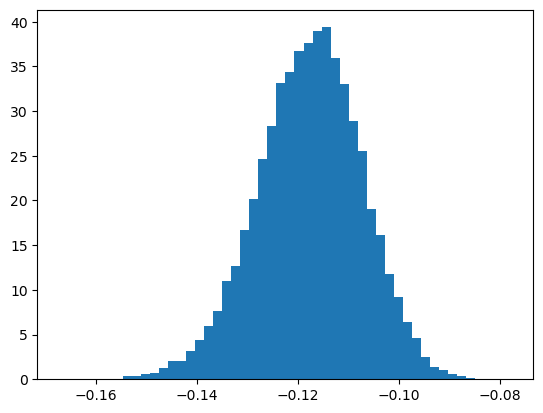

In [113]:
plt.hist(np.log10(SFRs),bins=50,density=True)

